In [45]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Victo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [3]:
api_key = 'INSERT YOUR API_KEY'

In [4]:
channel_ids = ['UCoOae5nYA7VqaXzerajD0lg',
               # more channels here
              ]

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [6]:
def get_channel_stats(youtube, channel_ids):
    
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids
    
    
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [7]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [8]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Ali Abdaal,5370000,411212454,859,UUoOae5nYA7VqaXzerajD0lg


In [9]:
playlist_id = "UUoOae5nYA7VqaXzerajD0lg"

In [10]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [11]:
len(video_ids)

856

In [12]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,Vie8QwUJfgY,Ali Abdaal,A hack to improve your skill level 📈,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, seneca, upskill, learn...",2024-04-01T12:00:22Z,10104,951,None,8,PT48S,hd,false
1,K-Y4NvGHMyc,Ali Abdaal,Boost your energy by working harder ⚡️,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-03-31T12:00:22Z,24119,1664,None,15,PT38S,hd,false
2,-mSBv-BLv6M,Ali Abdaal,Can you make productivity feel good? 🤔,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, productivity, feel goo...",2024-03-30T13:00:00Z,16966,1096,None,5,PT47S,hd,false
3,uYTEFWVPx_8,Ali Abdaal,Stop Wasting Time - 11 Tools to Double Your Focus,Check out Rize using this link: https://rize.i...,"[Ali Abdaal, Ali abdal, time management skills...",2024-03-29T14:00:45Z,134373,5707,None,295,PT26M11S,hd,false
4,3wuVuqgu45M,Ali Abdaal,How I tricked my brain into enjoying work 👨‍💻,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, enjoying my work, brai...",2024-03-29T13:00:06Z,24852,1978,None,9,PT53S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04T23:13:51Z,93646,2286,None,143,PT2M35S,hd,false
852,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09T18:45:18Z,16853,124,None,6,PT2M11S,hd,false
853,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27T09:04:49Z,41280,297,None,9,PT2M18S,hd,false
854,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05T09:05:29Z,63313,772,None,39,PT2M29S,hd,false


In [14]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments) 

In [15]:
comments_df = get_comments_in_videos(youtube, video_ids)
comments_df

Could not get comments for video P6xJm38guuM


,video_id,comments
0,Vie8QwUJfgY,"[skill issue, Very true. This actually works f..."
1,K-Y4NvGHMyc,[I dont think its necessarily working harder. ...
2,-mSBv-BLv6M,[Best work tends to come out if we're in the c...
3,uYTEFWVPx_8,[Sign up to my free 7 day focus crash course h...
4,3wuVuqgu45M,"[Which class? 😂, Wow, Working for somebody els..."
...,...,...
850,7APfFjfnNBc,"[I bet he can't play anymore., Who is watching..."
851,gBpBLTSCb4s,"[Love ❤ Ali Abdaal, watching Ali's videos abou..."
852,Va0tSdPADpA,"[Wow ali ❤️, Ali 3rd viedeo, Where is ali?, wa..."
853,XJHM0fEH3ss,[Assalamualaikum sir with due respect I wants ...


In [16]:
comments_df['comments'][0]

['skill issue',
 'Very true. This actually works for anything, even life in general. Listen to all the advice you give to people.',
 'It’s called reciprocal teaching',
 'I think this is one of the main problems I have with my current position. We are understaffed to the point these ideas can’t take space in someone’s head.  One of many reasons I’m trying to get out',
 'I found a hindi word , Love from INDIA ❤🎉',
 "What's up with the comment section 💀",
 "I'm thoroughly impressed by the level of engagement in this thread. It's akin to witnessing a vibrant marketplace of ideas.💚",
 "This thread is a testament to the power of conversation to inspire, educate, and uplift. It's a force for good in the world.🌺"]

In [16]:
print(video_df.columns)

Index(['video_id', 'channelTitle', 'title', 'description', 'tags',
       'publishedAt', 'viewCount', 'likeCount', 'favouriteCount',
       'commentCount', 'duration', 'definition', 'caption'],
      dtype='object')


## Data pre-processing

In [19]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [20]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [21]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [22]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [23]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [24]:
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,0 days 00:00:48,PT48S
1,0 days 00:00:38,PT38S
2,0 days 00:00:47,PT47S
3,0 days 00:26:11,PT26M11S
4,0 days 00:00:53,PT53S
...,...,...
851,0 days 00:02:35,PT2M35S
852,0 days 00:02:11,PT2M11S
853,0 days 00:02:18,PT2M18S
854,0 days 00:02:29,PT2M29S


In [25]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [26]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,Vie8QwUJfgY,Ali Abdaal,A hack to improve your skill level 📈,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, seneca, upskill, learn...",2024-04-01 12:00:22+00:00,10104.0,951.0,NaN,8.0,PT48S,hd,false,Monday,0 days 00:00:48,7
1,K-Y4NvGHMyc,Ali Abdaal,Boost your energy by working harder ⚡️,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-03-31 12:00:22+00:00,24119.0,1664.0,NaN,15.0,PT38S,hd,false,Sunday,0 days 00:00:38,2
2,-mSBv-BLv6M,Ali Abdaal,Can you make productivity feel good? 🤔,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, productivity, feel goo...",2024-03-30 13:00:00+00:00,16966.0,1096.0,NaN,5.0,PT47S,hd,false,Saturday,0 days 00:00:47,5
3,uYTEFWVPx_8,Ali Abdaal,Stop Wasting Time - 11 Tools to Double Your Focus,Check out Rize using this link: https://rize.i...,"[Ali Abdaal, Ali abdal, time management skills...",2024-03-29 14:00:45+00:00,134373.0,5707.0,NaN,295.0,PT26M11S,hd,false,Friday,0 days 00:26:11,21
4,3wuVuqgu45M,Ali Abdaal,How I tricked my brain into enjoying work 👨‍💻,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal, enjoying my work, brai...",2024-03-29 13:00:06+00:00,24852.0,1978.0,NaN,9.0,PT53S,hd,false,Friday,0 days 00:00:53,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04 23:13:51+00:00,93646.0,2286.0,NaN,143.0,PT2M35S,hd,false,Wednesday,0 days 00:02:35,4
852,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09 18:45:18+00:00,16853.0,124.0,NaN,6.0,PT2M11S,hd,false,Monday,0 days 00:02:11,4
853,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27 09:04:49+00:00,41280.0,297.0,NaN,9.0,PT2M18S,hd,false,Wednesday,0 days 00:02:18,4
854,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05 09:05:29+00:00,63313.0,772.0,NaN,39.0,PT2M29S,hd,false,Tuesday,0 days 00:02:29,4


## EDA

### Best performing videos

C:\Users\Victo\AppData\Local\Temp\ipykernel_21120\73220587.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


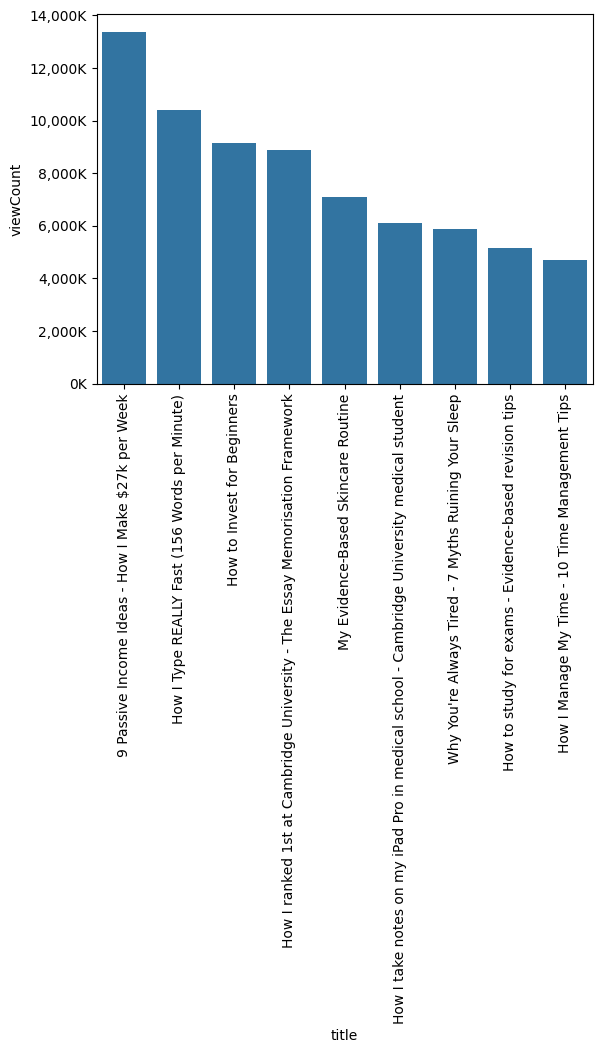

In [32]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Worst performing videos

C:\Users\Victo\AppData\Local\Temp\ipykernel_21120\171811544.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


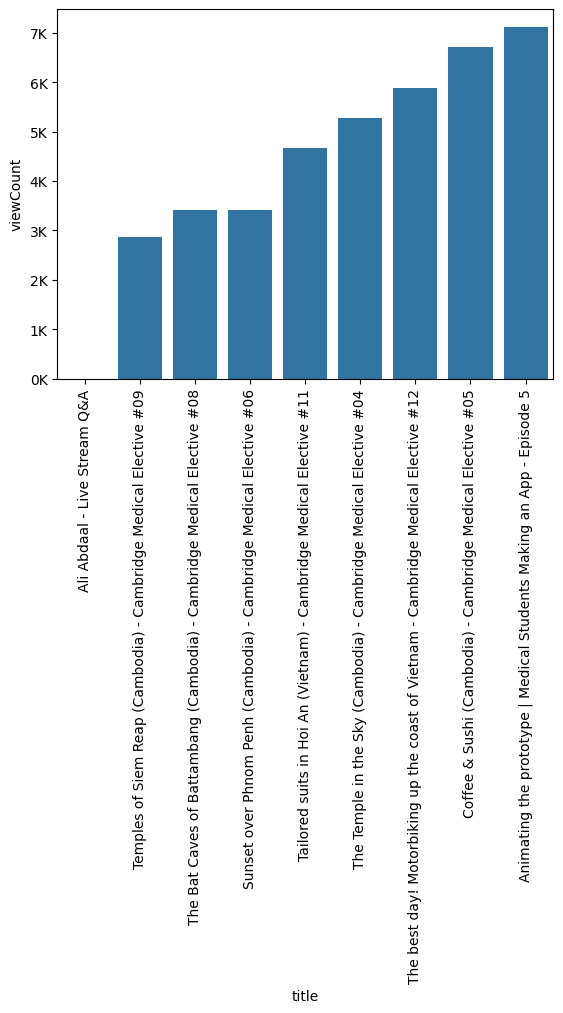

In [33]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### View distribution per video

<Axes: xlabel='channelTitle', ylabel='viewCount'>

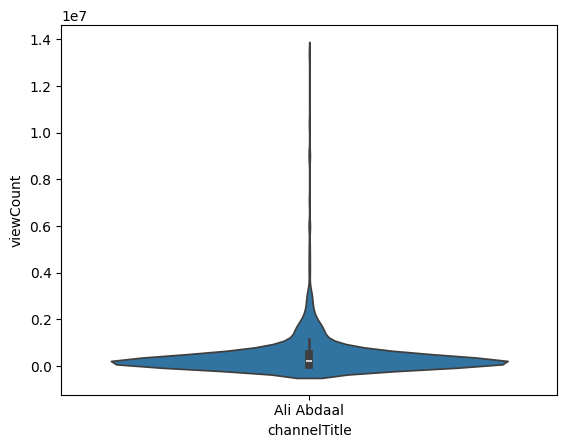

In [36]:
sns.violinplot(data=video_df, x="channelTitle", y="viewCount")

### Views VS Likes and comments

<Axes: xlabel='likeCount', ylabel='viewCount'>

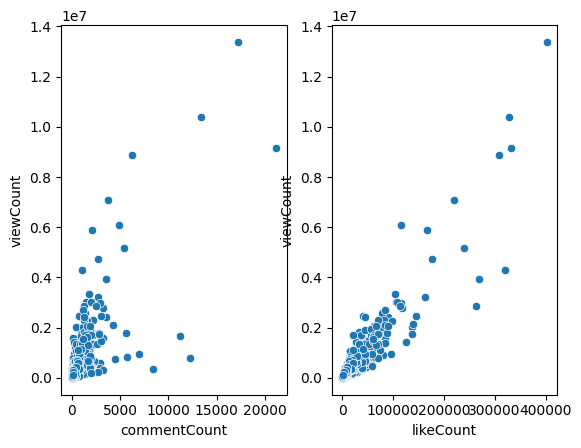

In [37]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

### Video duration

<Axes: xlabel='durationSecs', ylabel='Count'>

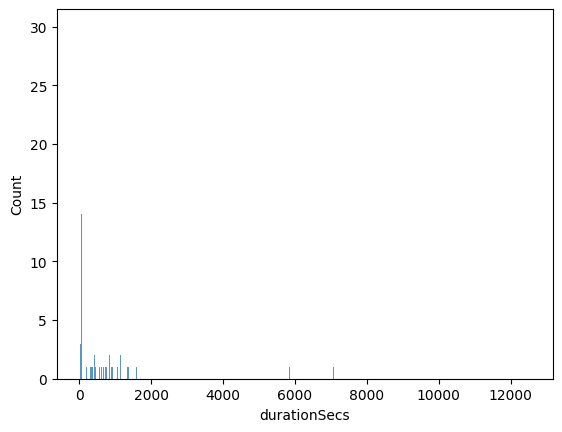

In [42]:
sns.histplot(data=video_df, x="durationSecs", bins=30)

### Wordcloud for video titles

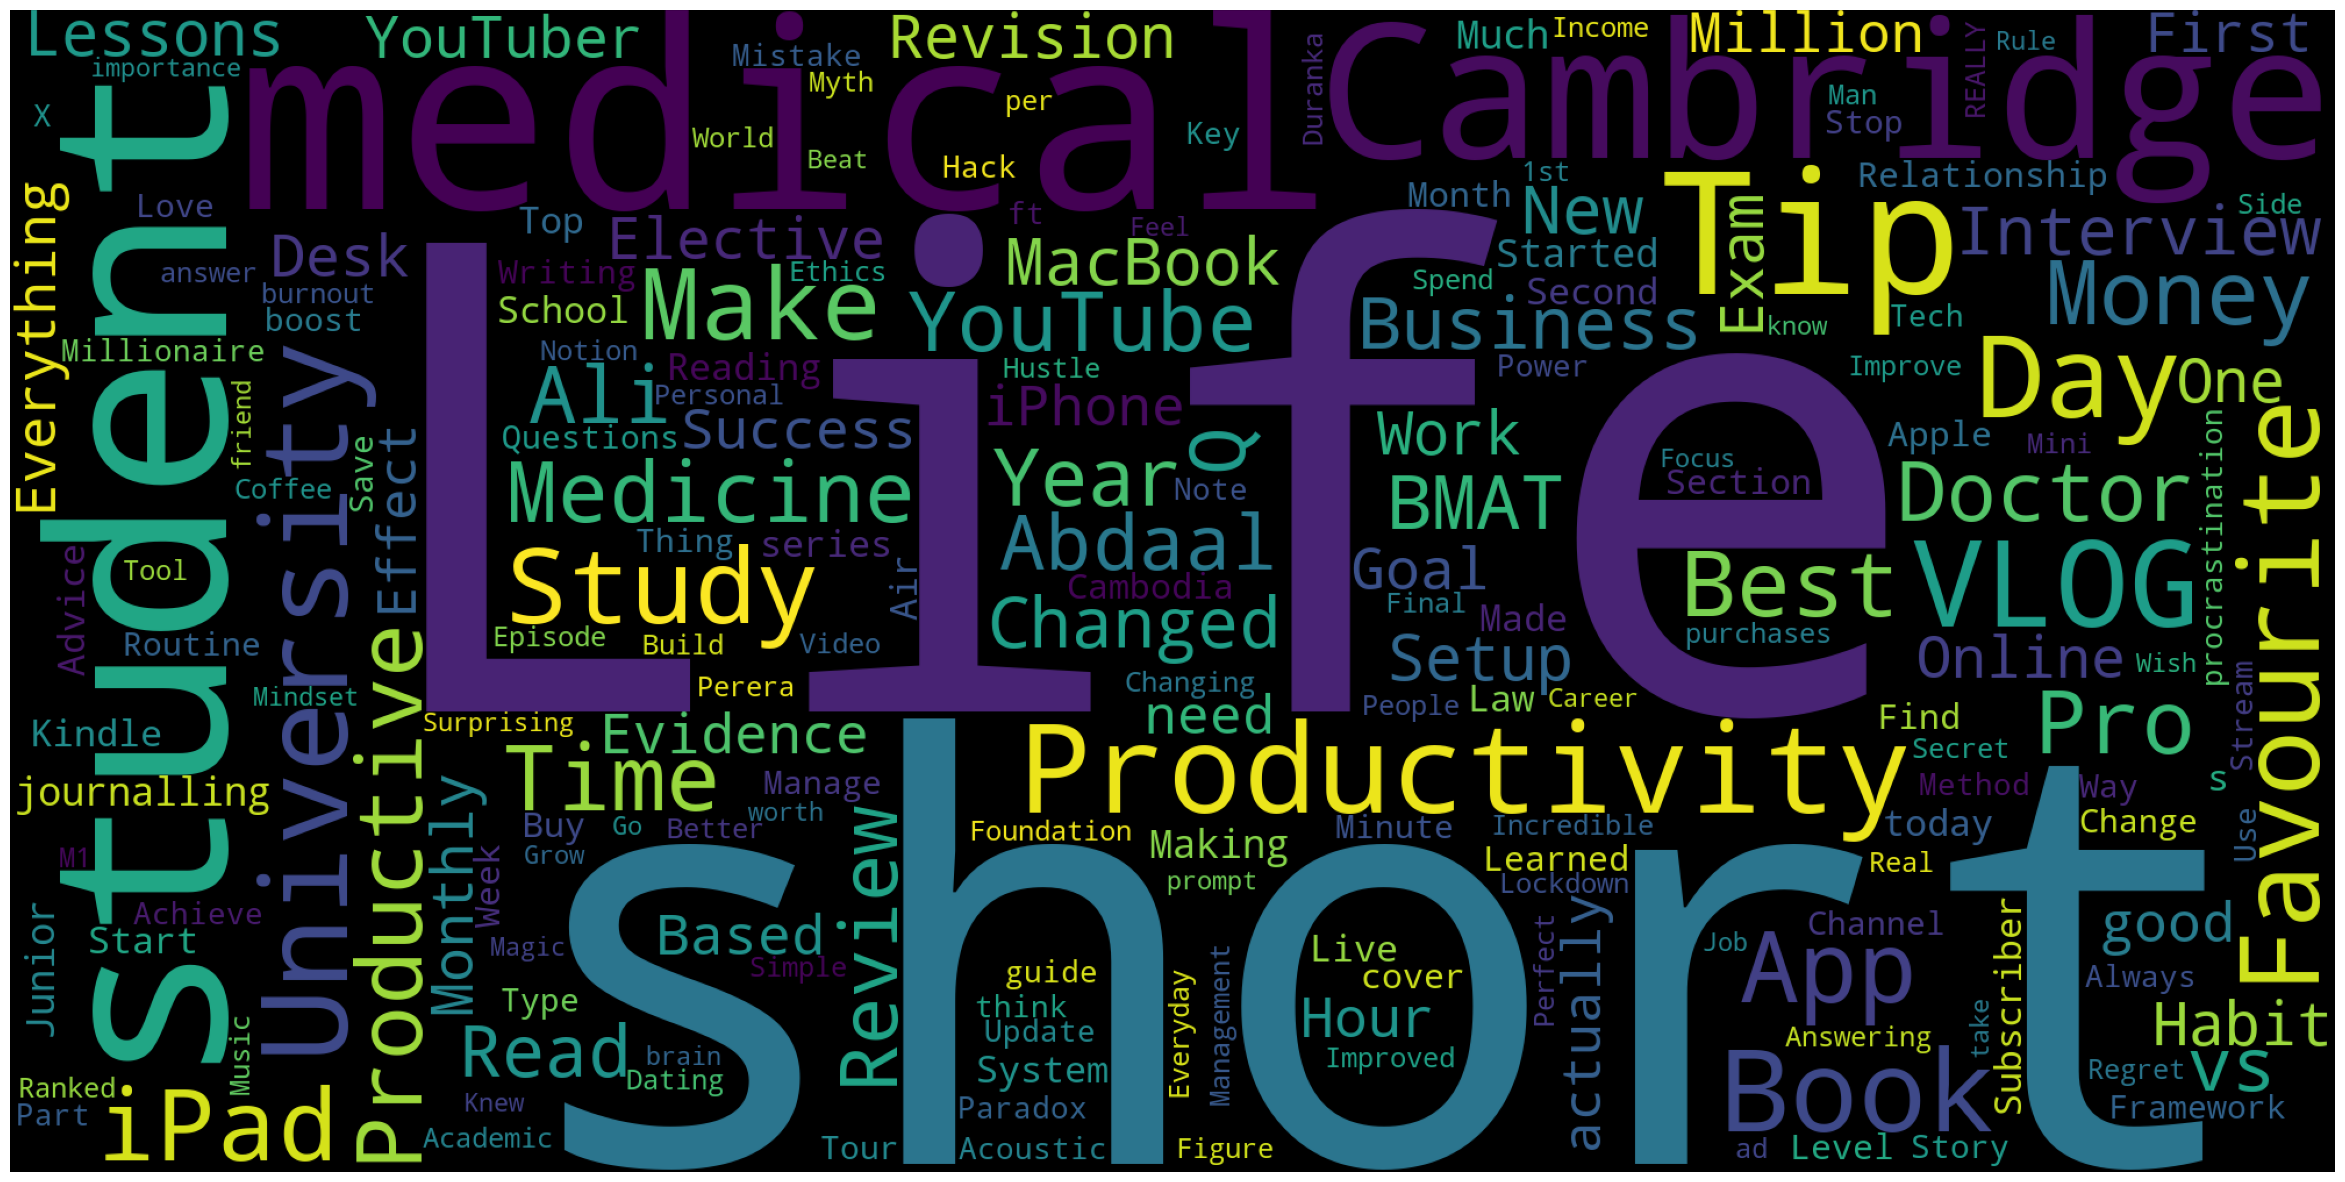

In [46]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Uploaded schedule

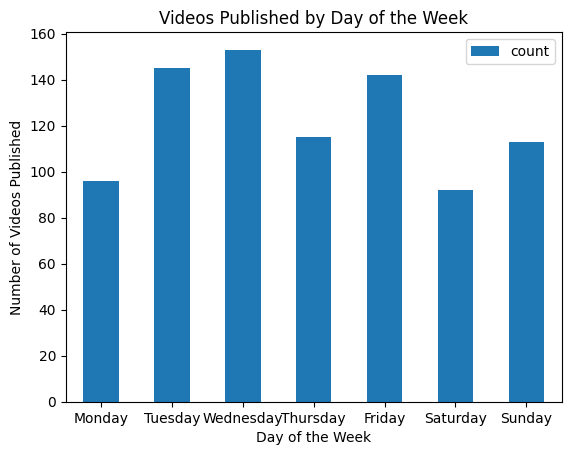

In [51]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.plot.bar(rot=0)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Videos Published')
plt.title('Videos Published by Day of the Week')
plt.show()